In [1]:
#!pip install transfer_ode


In [2]:
import torch
import torch.nn as nn
import argparse
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torchdiffeq import odeint_adjoint as odeint
from mpl_toolkits.mplot3d import Axes3D
import random


class Args:
    def __init__(self):
        pass 
    def assign(self,args):
        for key, val in args.items():
            if key != 'self':
                setattr(self, key, val)

In [3]:
import transfer_ode as tode
#tode.odeint = odeint

In [4]:
ADJOINT = False
if ADJOINT:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [5]:
import types
def assign_args(args_):
    for arg, val in args_.items():
        fs = []
        for f in globals().values():
            if type(f) == types.FunctionType:
                #print(f)
                try:
                    #print(f.args)
                    f.args = args
                except:
                    fs.append(f)
                    
                    #print(f'f, {id(f)}')
        for f in fs:
            #print(f'f, {id(f)}')
            f.__globals__[arg] = val
                    #f.__globals__["NDIMZ"] = args.hidden_size

In [6]:
#assign_args({"hu": 1})

In [7]:
# import sys,os,argparse
# from IPython.display import HTML
# CONFIG_FILE = '.config_ipynb'
# if os.path.isfile(CONFIG_FILE):
#     with open(CONFIG_FILE) as f:
#         sys.argv = f.read().split()
# else:
#     sys.argv = ['test_args.py', 'input_file', '--int_param', '12']

# parser = argparse.ArgumentParser('NeuralODE transfer demo')
# parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
# parser.add_argument('--tmax', type=float, default=5.)
# parser.add_argument('--dt', type=int, default=0.1)

# parser.add_argument('--method_rc', type=str, choices=['euler'], default='euler')
# parser.add_argument('--wout', type=str, default='analytic')
# parser.add_argument('--paramg', type=str, default='lin')

# parser.add_argument('--niters', type=int, default=100)
# parser.add_argument('--hidden_size', type=int, default=200)

# parser.add_argument('--test_freq', type=int, default=1)

# parser.add_argument('--viz', action='store_false')
# parser.add_argument('--gpu', type=int, default=0)
# parser.add_argument('--adjoint', action='store_false')
# args = parser.parse_args()
# p = args.int_param
# print(args.input_file,p)

In [8]:
def assign_vars(func, key, val):
    func.__globals__[key] = val

In [9]:
def LinOut(args, wout_gen, s, sd, true_y0, t):
    
    if args.wout == "analytic":
        
        wout, bias = wout_gen.get_wout(s.detach(),sd.detach(), true_y0, t)
    
    elif args.wout == "learned":
        
        wout, bias = wout_gen.get_wout()
        
    return wout, bias

In [10]:
def optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
             a1 = lambda t:1 + 0.*t,
             f = lambda t: torch.sin(t),#t**6#3*t**2#torch.sin(t)
             ics = torch.tensor(np.arange(-2, 2.9, 0.25), dtype = torch.float32),#torch.linspace(-7.,7.,200),
             method : str = "dopri5", 
             tmax : float = 5,
             #dt   : int   = 0.01,
             method_rc: str = "euler",
             wout : str = "analytic",
             paramg : str = "lin",
             niters : int = 100,
             hidden_size : int = 200,
             test_freq : int = 1,
             viz = False,#'store_false',
             gpu : int = 0,
             adjoint = 'store_false',
             random_sampling = True,
             n_timepoints = 50,
             regularization = 700,
             l1_reg_strength = 0
            ):
    args = Args()
    
    args.assign(locals())
    tode.args = args
    #assign_args({"args": args})
    
    dt=tmax/n_timepoints
    
    
    globals()["args"] = args
    
    print(args)
    ii = 0
    NDIMZ = args.hidden_size
    
    
    assign_vars(tode.compute_s_sdot, "args", args)
    assign_vars(tode.compute_s_sdot, "NDIMZ", NDIMZ)
    
    
    #tode.args = args
    
    
    #assign_args({"NDIMZ": NDIMZ})
    
    # define coefficients as lambda functions, used for gt and wout_analytic
    

    diffeq_init = tode.diffeq(a0,a1,f)
    gt_generator = tode.base_diffeq(diffeq_init)
    estim_generator = tode.estim_diffeq(diffeq_init)
    true_y0 = torch.tensor([[5.]])
    if not random_sampling:
        t = torch.arange(0.,args.tmax,args.dt)
    else:
        t = torch.rand(n_timepoints) *tmax
        t = t.sort().values
    
    t = t.reshape(-1,1)
    
    assign_vars(tode.compute_s_sdot, "t", t)
    assign_args({"t": t})

    true_y = gt_generator.get_solution(true_y0,t.ravel())

    # wout generator
    if args.wout == 'analytic':
        wout_gen = tode.Transformer_Analytic(a0, a1, f, regularization)
    elif args.wout == 'learned':
        #optimizer = optim.Adam(func.parameters(),lr=1e-5)
        wout_gen = tode.Transformer_Learned(NDIMZ, true_y0.shape[1])
    
    # hidden state generator
    func = tode.ODEFunc(NDIMZ)
    # func.upper.weight

    #if args.wout  == 'analytic':
    optimizer = optim.Adam(func.parameters(),lr=1e-5)
    #     elif args.wout == 'learned':
    #         optimizer = optim.Adam(func.parameters(), lr=1e-3, weight_decay=1e-6)
    #     #     optimizer = optim.SGD([
    #         {'params': func.parameters()},
    #         {'params': wout_gen.parameters(), 'lr': 1e-4, 'weight_decay': 1e-3}
    #     ], lr=1e-3)


    # true_y0 = torch.tensor([[3.]])
    param = tode.Parametrization(args.paramg)
    zinit_ = torch.ones(NDIMZ).reshape(1, NDIMZ)
    loss_collector = []
    for itr in range(1, args.niters + 1):
        
        
        
        optimizer.zero_grad()

        zinit = func.get_z0(zinit_)
        #print(f'f, {id(tode.compute_s_sdot)}')
        s,sd = tode.compute_s_sdot(func,zinit,t,param)
        
        # print(s[0],sd[0])
        # if (itr-1)%200==0:
        wout, bias = wout_gen.get_wout(s.detach(),sd.detach(), true_y0, t)
        #print(f'bias: {bias}')

        # wout = torch.ones(100,1)
        # wout = wout_gen.get_wout(s.detach(), sd.detach(), true_y0, t)
        # print(wout)
        # wout = wout.detach()

        pred_y = true_y0 + torch.mm(s, wout) + bias
        pred_ydot = torch.mm(sd, wout)
        lst = (a1(t).reshape(-1,1))*pred_ydot + (a0(t).reshape(-1,1))*pred_y - f(t).reshape(-1,1)
        # lst = wout-1.
        # l2_reg = None
        l1_reg = torch.linalg.norm(wout.abs())

        # for name,paramss in func.named_parameters():
        #     if name == 'upper.weight':
        #         # print(paramss)
        #         l2_reg = torch.sum(torch.abs(paramss))
        # print(func.upper.weight.detach().cpu().numpy())
        # print(l2_reg)
        loss = torch.mean(torch.square(lst)) + l1*l1_reg
        loss.backward()
        optimizer.step()
        loss_collector.append(torch.square(lst).mean().item())
        if itr % args.test_freq == 0:
            # print(loss.item())
            with torch.no_grad():
                #print(f'f, {id(tode.compute_s_sdot)}')
                s, sd = tode.compute_s_sdot(func, zinit, t, param)
                

                wout, bias = wout_gen.get_wout(s, sd, true_y0, t)
                #     # wout = torch.ones(100, 1)
                #
                # elif args.wout == 'learned':
                #     wout = wout_gen.get_wout()

                pred_y = true_y0[0,0].reshape(1, 1) + torch.mm(s, wout)[:,0] + bias
                pred_y = pred_y.reshape(-1,1,1)
                # loss = torch.mean(torch.abs(pred_y - true_y))
                # print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                tode.visualize(true_y, pred_y, func, ii,loss_collector,s)
                ii += 1



        # torch.save(func.state_dict(), 'func_dict_wout')

    with torch.no_grad():

        s, sd = tode.compute_s_sdot(func, zinit, t, param)
        #inference for other ICs
        #ics = torch.linspace(-7.,7.,200)


        # results_df = np.zeros((len(ics),6))
        y0 = ics.reshape(1,-1)
        s1 = time.time()
        wout, bias = wout_gen.get_wout(s, sd, y0, t)
        pred_y = y0 + torch.mm(s, wout) + bias
        s2 = time.time()
        print(f'all_ics:{s2-s1}')

        
        rmsr = 0.
        true_ys= torch.zeros(len(pred_y),len(ics))
        estim_ys = torch.zeros(len(pred_y), len(ics))
        # print(true_ys.shape)
        s1 = time.time()
        # y0 = ic.reshape(1,1)
        true_y = gt_generator.get_solution(y0.reshape(-1,1),t.ravel())
        true_ys = true_y.reshape(len(pred_y),len(ics))
        s2 = time.time()
        print(f'gt_ics:{s2 - s1}')

        s1 = time.time()
        # for ic_index, ic in enumerate(ics):
        #     y0 = ic.reshape(1, 1)
        true_y = estim_generator.get_solution(y0.reshape(-1,1), t.ravel())
        estim_ys = true_y.reshape(len(pred_y),len(ics))
        s2 = time.time()
        
        prediction_residuals = ((pred_y - true_ys) ** 2)
        estimation_residuals = ((estim_ys - true_ys) ** 2)
        
        #print(f'estim_ics:{s2 - s1}')
        print(f'prediction mse:{prediction_residuals.mean()} pm {prediction_residuals.std()}')
        #print(f'estim mse {estimation_residuals.mean()} pm {estimation_residuals.std()}')
        visualize_ = False
        if visualize_:
            fig,ax = plt.subplots(1,3,figsize=(15,4))
            plt.sca(ax[0])
            pred, gt, estim = pred_y, true_ys, estim_ys
            plt.plot(gt, alpha = 0.3, color = "red")
            plt.plot(pred, alpha = 0.3, color = "blue")
            #plt.plot(estim, alpha = 0.3, color = "green")
            plt.sca(ax[1])
            plt.plot(prediction_residuals, alpha = 0.1, color = "red")
            #plt.plot(prediction_residuals, alpha = 0.1, color = "red")
            plt.yscale("log")
            
        score = prediction_residuals.mean()
        return score, pred_y, true_y, estim_ys

In [11]:
%%time
losses_l1 = []
for l1 in [0.0001, 0.001, 0.01, 0.1, 0]:
    score, pred, gt, estim  = optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
                                a1 = lambda t:1 + 0.*t,
                                f = lambda t: torch.sin(t),
                                n_timepoints = 500,
                                regularization = 20,
                                l1_reg_strength = l1)
    data_point = {"score" : float(score), "l1_reg" : l1}
    losses_l1.append(data_point) #[str(l1)] = (score)

all_ics:0.002653837203979492
gt_ics:0.12656021118164062
prediction mse:0.0013279332779347897 pm 0.0035581865813583136
all_ics:0.0025787353515625
gt_ics:0.14402413368225098
prediction mse:0.00033040984999388456 pm 0.0008460157550871372
all_ics:0.002515077590942383
gt_ics:0.1261000633239746
prediction mse:0.000988996820524335 pm 0.002561078406870365
all_ics:0.0030629634857177734
gt_ics:0.1319739818572998
prediction mse:0.000964207632932812 pm 0.0028824566397815943
all_ics:0.0023660659790039062
gt_ics:0.14025592803955078
prediction mse:0.00040388351771980524 pm 0.0011323749786242843
CPU times: user 3min 45s, sys: 33 s, total: 4min 18s
Wall time: 3min 35s


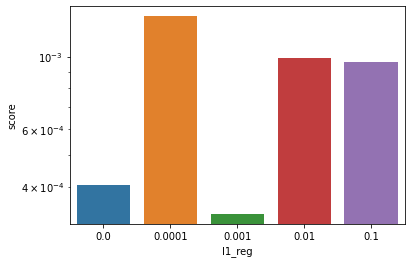

In [12]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(losses_l1)
sns.barplot(data = df, x = "l1_reg", y = "score")
plt.yscale("log")

In [13]:
%%time
losses_l2 = []
for l2 in [0, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]:
    score, pred, gt, estim  = optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
                                a1 = lambda t:1 + 0.*t,
                                f = lambda t: torch.sin(t),
                                n_timepoints = 50,
                                regularization = 20,
                                l1_reg_strength = 0.0001)
    data_point = {"score" : float(score), "l2_reg" : l2}
    losses_l2.append(data_point) #[str(l1)] = (score)

all_ics:0.0005822181701660156
gt_ics:0.10233902931213379
prediction mse:0.02143574133515358 pm 0.06906456500291824
all_ics:0.0008671283721923828
gt_ics:0.11440086364746094
prediction mse:0.004318441729992628 pm 0.01119331642985344
all_ics:0.0010449886322021484
gt_ics:0.12088584899902344
prediction mse:0.001108609838411212 pm 0.0037482401821762323
all_ics:0.0007321834564208984
gt_ics:0.11633682250976562
prediction mse:0.0011738816974684596 pm 0.003678813111037016
all_ics:0.0008661746978759766
gt_ics:0.1214909553527832
prediction mse:0.0024896503891795874 pm 0.005368334706872702
all_ics:0.00090789794921875
gt_ics:0.10860180854797363
prediction mse:0.012959960848093033 pm 0.04253804311156273
all_ics:0.0007412433624267578
gt_ics:0.11099791526794434
prediction mse:0.02682616002857685 pm 0.04699307307600975
all_ics:0.0008602142333984375
gt_ics:0.12718915939331055
prediction mse:0.001835374510847032 pm 0.006712167523801327
all_ics:0.0007929801940917969
gt_ics:0.12125802040100098
prediction ms

In [14]:
df = pd.DataFrame(losses_l2)
df.head()

,score,l2_reg
0,0.021436,0.000
1,0.004318,0.001
2,0.001109,0.010
3,0.001174,0.100
4,0.002490,1.000


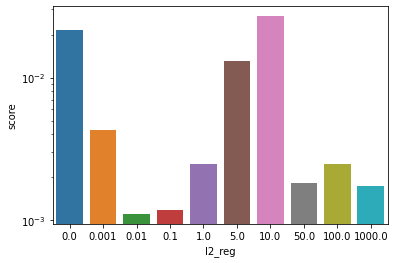

In [15]:
import pandas as pd

sns.barplot(data = df, x = "l2_reg", y = "score")
plt.yscale("log")

In [16]:
%%time
score, pred, gt, estim  = optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
                            a1 = lambda t:1 + 0.*t,
                            f = lambda t: torch.sin(t),
                            n_timepoints = 500,
                            regularization = 5,
                            #l1_reg_strength = 0.0001,
                            visualize_ = True)

TypeError: optimize() got an unexpected keyword argument 'visualize_'

In [17]:
%%time
pred, gt, estim  = optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
                            a1 = lambda t:1 + 0.*t,
                            f = lambda t: torch.sin(t),
                            n_timepoints = 50,
                            #regularization = 0.001,
                           wout = "learned")

TypeError: get_wout() takes 1 positional argument but 5 were given

In [18]:
# plt.figure(figsize = (14, 4))
# for i in range(y.shape[0]):
#     plt.plot(gt[:,i], alpha = 0.3, color = "red")
#     plt.plot(pred[:,i], alpha = 0.3, color = "blue")
#     plt.plot(estim[:,i], alpha = 0.3, color = "green")

In [19]:
for i in range(y.shape[0]):
    plt.plot((y[:,i] - pred[:,i])**2, alpha = 0.3, color = "red")
plt.yscale("log")
    #plt.plot(, alpha = 0.3, color = "blue")

NameError: name 'y' is not defined

In [ ]:
compute_s_sdot

In [ ]:
for i in dir(locals()):
    print(i)
    if type(i) == type(hi):
        print(i)

In [ ]:
NDIMZ = 5
dir(NDIMZ)

In [ ]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

In [ ]:
globals().values()

In [ ]:

#print([f for f in globals().values() ])